In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import unet
from unet import utils
from unet.datasets import circles

In [2]:
train_dataset, validation_dataset = circles.load_data(1000, nx=256, ny=256, splits=(0.8, 0.2))

In [3]:
from tensorflow.python import ipu

cfg = ipu.config.IPUConfig()
cfg.auto_select_ipus = 1
cfg.configure_ipu_system()

In [4]:
with ipu.ipu_strategy.IPUStrategy(enable_dataset_iterators=False).scope():
    unet_model = unet.build_model(channels=circles.channels,
                                  num_classes=circles.classes,
                                  layer_depth=3,
                                  filters_root=16)
    unet.finalize_model(unet_model)
    
    trainer = unet.Trainer(checkpoint_callback=False)    
    trainer.fit(unet_model,
                train_dataset,
                validation_dataset,
                epochs=5,
                batch_size=1)
    
    prediction = unet_model.predict(validation_dataset.batch(batch_size=1, drop_remainder=True))

Epoch 1/5
800/800 [==============================] - 11s 14ms/step - loss: 0.1382 - categorical_crossentropy: 0.1382 - categorical_accuracy: 0.9723 - mean_iou: 0.5369 - dice_coefficient: 0.9251 - auc: 0.9868 - val_loss: 0.0439 - val_categorical_crossentropy: 0.0439 - val_categorical_accuracy: 0.9739 - val_mean_iou: 0.6404 - val_dice_coefficient: 0.9757 - val_auc: 0.9980
Epoch 2/5
800/800 [==============================] - 5s 6ms/step - loss: 0.0542 - categorical_crossentropy: 0.0542 - categorical_accuracy: 0.9738 - mean_iou: 0.6259 - dice_coefficient: 0.9716 - auc: 0.9966 - val_loss: 0.0476 - val_categorical_crossentropy: 0.0476 - val_categorical_accuracy: 0.9739 - val_mean_iou: 0.6746 - val_dice_coefficient: 0.9727 - val_auc: 0.9976
Epoch 3/5
800/800 [==============================] - 12s 15ms/step - loss: 0.0466 - categorical_crossentropy: 0.0466 - categorical_accuracy: 0.9744 - mean_iou: 0.6511 - dice_coefficient: 0.9756 - auc: 0.9974 - val_loss: 0.0268 - val_categorical_crossentrop

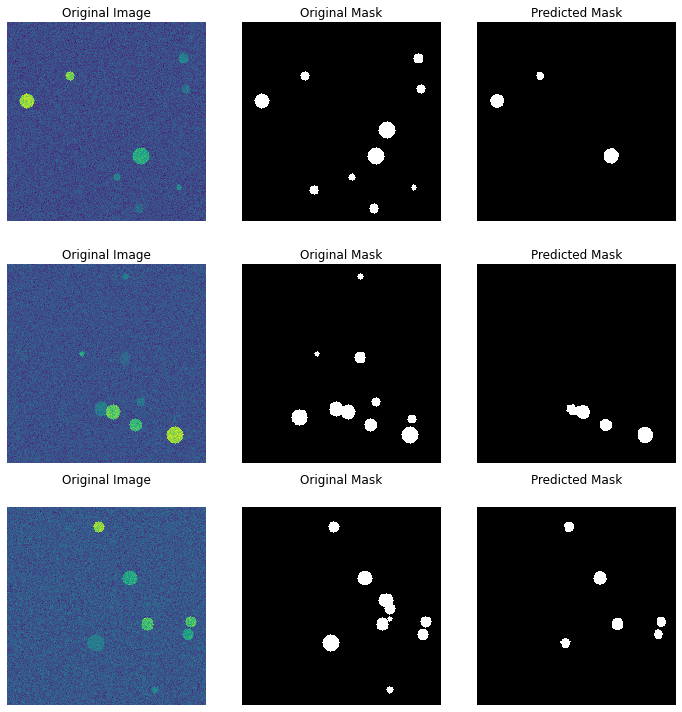

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()